<a href="https://colab.research.google.com/github/MyDearGreatTeacher/Python/blob/master/DCGAN_CIFAR_10(20190928).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-

# 使用生成對抗網路生成CIFAR-10圖片


from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import save_image

dataset = CIFAR10(root='./data', download=True,
        transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

for batch_idx, data in enumerate(dataloader):
    real_images, _ = data
    batch_size = real_images.size(0)
    print ('#{} has {} images.'.format(batch_idx, batch_size))
    if batch_idx % 100 == 0:
        path = './data/CIFAR10_shuffled_batch{:03d}.png'.format(batch_idx)
        save_image(real_images, path, normalize=True)

"""搭建生成網路和鑒別網路"""

import torch.nn as nn

# 搭建生成網路
latent_size = 64 # 潛在大小
n_channel = 3 # 輸出通道數
n_g_feature = 64 # 生成網路隱藏層大小
gnet = nn.Sequential( 
        # 輸入大小 = (64, 1, 1)
        nn.ConvTranspose2d(latent_size, 4 * n_g_feature, kernel_size=4,
                bias=False),
        nn.BatchNorm2d(4 * n_g_feature),
        nn.ReLU(),
        # 大小 = (256, 4, 4)
        nn.ConvTranspose2d(4 * n_g_feature, 2 * n_g_feature, kernel_size=4,
                stride=2, padding=1, bias=False),
        nn.BatchNorm2d(2 * n_g_feature),
        nn.ReLU(),
        # 大小 = (128, 8, 8)
        nn.ConvTranspose2d(2 * n_g_feature, n_g_feature, kernel_size=4,
                stride=2, padding=1, bias=False),
        nn.BatchNorm2d(n_g_feature),
        nn.ReLU(),
        # 大小 = (64, 16, 16)
        nn.ConvTranspose2d(n_g_feature, n_channel, kernel_size=4,
                stride=2, padding=1),
        nn.Sigmoid(),
        # 圖片大小 = (3, 32, 32)
        )
print (gnet)

# 搭建鑒別網路
n_d_feature = 64 # 鑒別網路隱藏層大小
dnet = nn.Sequential( 
        # 圖片大小 = (3, 32, 32)
        nn.Conv2d(n_channel, n_d_feature, kernel_size=4,
                stride=2, padding=1),
        nn.LeakyReLU(0.2),
        # 大小 = (64, 16, 16)
        nn.Conv2d(n_d_feature, 2 * n_d_feature, kernel_size=4,
                stride=2, padding=1, bias=False),
        nn.BatchNorm2d(2 * n_d_feature),
        nn.LeakyReLU(0.2),
        # 大小 = (128, 8, 8)
        nn.Conv2d(2 * n_d_feature, 4 * n_d_feature, kernel_size=4,
                stride=2, padding=1, bias=False),
        nn.BatchNorm2d(4 * n_d_feature),
        nn.LeakyReLU(0.2),
        # 大小 = (256, 4, 4)
        nn.Conv2d(4 * n_d_feature, 1, kernel_size=4),
        # 對數賠率張量大小 = (1, 1, 1)
        )
print(dnet)

"""初始化權重值"""

import torch.nn.init as init

def weights_init(m): # 用於初始化權重值的函數
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)

gnet.apply(weights_init)
dnet.apply(weights_init)

import torch
import torch.optim

# 損失
criterion = nn.BCEWithLogitsLoss()

# 優化器
goptimizer = torch.optim.Adam(gnet.parameters(),
        lr=0.0002, betas=(0.5, 0.999))
doptimizer = torch.optim.Adam(dnet.parameters(), 
        lr=0.0002, betas=(0.5, 0.999))

# 用於測試的固定雜訊,用來查看相同的潛在張量在訓練過程中生成圖片的變換
batch_size = 64
fixed_noises = torch.randn(batch_size, latent_size, 1, 1)

# 訓練過程
epoch_num = 10
for epoch in range(epoch_num):
    for batch_idx, data in enumerate(dataloader):
        # 載入本批次數據
        real_images, _ = data
        batch_size = real_images.size(0)
        
        # 訓練鑒別網路
        labels = torch.ones(batch_size) # 真實資料對應標籤為1
        preds = dnet(real_images) # 對真實資料進行判別
        outputs = preds.reshape(-1)
        dloss_real = criterion(outputs, labels) # 真實資料的鑒別器損失
        dmean_real = outputs.sigmoid().mean()
                # 計算鑒別器將多少比例的真資料判定為真,僅用於輸出顯示
        
        noises = torch.randn(batch_size, latent_size, 1, 1) # 潛在雜訊
        fake_images = gnet(noises) # 生成假資料
        labels = torch.zeros(batch_size) # 假資料對應標籤為0
        fake = fake_images.detach()
                # 使得梯度的計算不回溯到生成網路,可用於加快訓練速度.刪去此步結果不變
        preds = dnet(fake) # 對假資料進行鑒別
        outputs = preds.view(-1)
        dloss_fake = criterion(outputs, labels) # 假數據的鑒別器損失
        dmean_fake = outputs.sigmoid().mean()
                # 計算鑒別器將多少比例的假資料判定為真,僅用於輸出顯示
        
        dloss = dloss_real + dloss_fake # 總的鑒別器損失
        dnet.zero_grad()
        dloss.backward()
        doptimizer.step()
        
        # 訓練生成網路
        labels = torch.ones(batch_size)
                # 生成網路希望所有生成的資料都被認為是真資料
        preds = dnet(fake_images) # 把假資料通過鑒別網路
        outputs = preds.view(-1)
        gloss = criterion(outputs, labels) # 真資料看到的損失
        gmean_fake = outputs.sigmoid().mean()
                # 計算鑒別器將多少比例的假資料判定為真,僅用於輸出顯示
        gnet.zero_grad()
        gloss.backward()
        goptimizer.step()
        
        # 輸出本步訓練結果
        print('[{}/{}]'.format(epoch, epoch_num) +
                '[{}/{}]'.format(batch_idx, len(dataloader)) +
                '鑒別網路損失:{:g} 生成網路損失:{:g}'.format(dloss, gloss) +
                '真資料判真比例:{:g} 假資料判真比例:{:g}/{:g}'.format(
                dmean_real, dmean_fake, gmean_fake))
        if batch_idx % 100 == 0:
            fake = gnet(fixed_noises) # 由固定潛在張量生成假資料
            save_image(fake, # 保存假資料
                    './data/images_epoch{:02d}_batch{:03d}.png'.format(
                    epoch, batch_idx))


0it [00:00, ?it/s]

 99%|█████████▉| 169336832/170498071 [00:11<00:00, 32704554.01it/s]

#0 has 64 images.
#1 has 64 images.
#2 has 64 images.
#3 has 64 images.
#4 has 64 images.
#5 has 64 images.
#6 has 64 images.
#7 has 64 images.
#8 has 64 images.
#9 has 64 images.
#10 has 64 images.
#11 has 64 images.
#12 has 64 images.
#13 has 64 images.
#14 has 64 images.
#15 has 64 images.
#16 has 64 images.
#17 has 64 images.
#18 has 64 images.
#19 has 64 images.
#20 has 64 images.
#21 has 64 images.
#22 has 64 images.
#23 has 64 images.
#24 has 64 images.
#25 has 64 images.
#26 has 64 images.
#27 has 64 images.
#28 has 64 images.
#29 has 64 images.
#30 has 64 images.
#31 has 64 images.
#32 has 64 images.
#33 has 64 images.
#34 has 64 images.
#35 has 64 images.
#36 has 64 images.
#37 has 64 images.
#38 has 64 images.
#39 has 64 images.
#40 has 64 images.
#41 has 64 images.
#42 has 64 images.
#43 has 64 images.
#44 has 64 images.
#45 has 64 images.
#46 has 64 images.
#47 has 64 images.
#48 has 64 images.
#49 has 64 images.
#50 has 64 images.
#51 has 64 images.
#52 has 64 images.
#53

170500096it [00:30, 32704554.01it/s]                               

[0/10][12/782]鑒別網路損失:0.114335 生成網路損失:4.28682真資料判真比例:0.941775 假資料判真比例:0.0514799/0.0155434
[0/10][13/782]鑒別網路損失:0.118403 生成網路損失:4.55178真資料判真比例:0.937504 假資料判真比例:0.0504224/0.011949
[0/10][14/782]鑒別網路損失:0.11548 生成網路損失:4.3537真資料判真比例:0.925938 假資料判真比例:0.0355338/0.0140807
[0/10][15/782]鑒別網路損失:0.118841 生成網路損失:4.32503真資料判真比例:0.93491 假資料判真比例:0.0480385/0.0146079
[0/10][16/782]鑒別網路損失:0.100295 生成網路損失:4.73057真資料判真比例:0.950077 假資料判真比例:0.0464761/0.0096752
[0/10][17/782]鑒別網路損失:0.0873794 生成網路損失:4.72286真資料判真比例:0.942796 假資料判真比例:0.0266035/0.00991072
[0/10][18/782]鑒別網路損失:0.0766656 生成網路損失:4.57507真資料判真比例:0.95323 假資料判真比例:0.0273004/0.0110983
[0/10][19/782]鑒別網路損失:0.0823253 生成網路損失:4.85084真資料判真比例:0.962219 假資料判真比例:0.0422754/0.00854626
[0/10][20/782]鑒別網路損失:0.0571986 生成網路損失:5.19866真資料判真比例:0.968597 假資料判真比例:0.0245082/0.00600897
[0/10][21/782]鑒別網路損失:0.0813567 生成網路損失:4.74792真資料判真比例:0.941549 假資料判真比例:0.0195062/0.00966861
[0/10][22/782]鑒別網路損失:0.0672792 生成網路損失:5.33829真資料判真比例:0.97889 假資料判真比例:0.044269/0.00561673
[0/10][23/782]鑒別網

In [2]:
!ls

data  sample_data


In [3]:
%cd data
!ls

/content/data
cifar-10-batches-py	       images_epoch04_batch300.png
cifar-10-python.tar.gz	       images_epoch04_batch400.png
CIFAR10_shuffled_batch000.png  images_epoch04_batch500.png
CIFAR10_shuffled_batch100.png  images_epoch04_batch600.png
CIFAR10_shuffled_batch200.png  images_epoch04_batch700.png
CIFAR10_shuffled_batch300.png  images_epoch05_batch000.png
CIFAR10_shuffled_batch400.png  images_epoch05_batch100.png
CIFAR10_shuffled_batch500.png  images_epoch05_batch200.png
CIFAR10_shuffled_batch600.png  images_epoch05_batch300.png
CIFAR10_shuffled_batch700.png  images_epoch05_batch400.png
images_epoch00_batch000.png    images_epoch05_batch500.png
images_epoch00_batch100.png    images_epoch05_batch600.png
images_epoch00_batch200.png    images_epoch05_batch700.png
images_epoch00_batch300.png    images_epoch06_batch000.png
images_epoch00_batch400.png    images_epoch06_batch100.png
images_epoch00_batch500.png    images_epoch06_batch200.png
images_epoch00_batch600.png    images_epoch06_b

In [8]:
%cd ../data
!ls

/content/data
cifar-10-batches-py	       images_epoch04_batch300.png
cifar-10-python.tar.gz	       images_epoch04_batch400.png
CIFAR10_shuffled_batch000.png  images_epoch04_batch500.png
CIFAR10_shuffled_batch100.png  images_epoch04_batch600.png
CIFAR10_shuffled_batch200.png  images_epoch04_batch700.png
CIFAR10_shuffled_batch300.png  images_epoch05_batch000.png
CIFAR10_shuffled_batch400.png  images_epoch05_batch100.png
CIFAR10_shuffled_batch500.png  images_epoch05_batch200.png
CIFAR10_shuffled_batch600.png  images_epoch05_batch300.png
CIFAR10_shuffled_batch700.png  images_epoch05_batch400.png
images_epoch00_batch000.png    images_epoch05_batch500.png
images_epoch00_batch100.png    images_epoch05_batch600.png
images_epoch00_batch200.png    images_epoch05_batch700.png
images_epoch00_batch300.png    images_epoch06_batch000.png
images_epoch00_batch400.png    images_epoch06_batch100.png
images_epoch00_batch500.png    images_epoch06_batch200.png
images_epoch00_batch600.png    images_epoch06_b

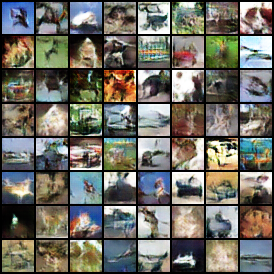

In [10]:
import cv2
img = cv2.imread('images_epoch09_batch700.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)